In [1]:
import json
import numpy as np
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from ppo_model import RllibPPOModel
from gym import spaces
import bc
print(bc.device)

cpu


In [2]:
DATA_FOLDER = "../mocker/fox_bad_1"
LOAD_CHECKPOINT = None
SAVE_CHECKPOINT = "./bc_agent_3"
BATCH_SIZE = 64

In [3]:
states, actions, dim_states, num_actions = bc.states_from_folder(DATA_FOLDER)
print(f"{len(states)} steps. dim_states {dim_states}, num_actions {num_actions}")
train_dataloader, test_dataloader = bc.datasets(states, actions, batch_size=BATCH_SIZE)

33129 steps. dim_states 87, num_actions 69


Epoch 0     Train Loss: 3.18  Test Loss: 2.28 
Epoch 1     Train Loss: 2.15  Test Loss: 2.04 
Epoch 2     Train Loss: 2.02  Test Loss: 1.93 
Epoch 3     Train Loss: 1.96  Test Loss: 1.93 
Epoch 4     Train Loss: 1.92  Test Loss: 1.89 
Epoch 5     Train Loss: 1.89  Test Loss: 1.87 
Epoch 6     Train Loss: 1.86  Test Loss: 1.86 
Epoch 7     Train Loss: 1.85  Test Loss: 1.84 
Epoch 8     Train Loss: 1.83  Test Loss: 1.83 
Epoch 9     Train Loss: 1.81  Test Loss: 1.79 
Epoch 10    Train Loss: 1.77  Test Loss: 1.78 
Epoch 11    Train Loss: 1.76  Test Loss: 1.73 
Epoch 12    Train Loss: 1.74  Test Loss: 1.74 
Epoch 13    Train Loss: 1.73  Test Loss: 1.77 
Epoch 14    Train Loss: 1.71  Test Loss: 1.72 
Epoch 15    Train Loss: 1.70  Test Loss: 1.70 
Epoch 16    Train Loss: 1.69  Test Loss: 1.69 
Epoch 17    Train Loss: 1.68  Test Loss: 1.63 
Epoch 18    Train Loss: 1.65  Test Loss: 1.66 
Epoch 19    Train Loss: 1.67  Test Loss: 1.66 
Epoch 20    Train Loss: 1.64  Test Loss: 1.62 
Epoch 21    T

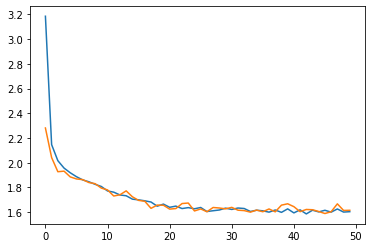

In [4]:
bc_agent = bc.LinearAgent(dim_states, num_actions)
if LOAD_CHECKPOINT:
    bc_agent.load_state(LOAD_CHECKPOINT)
else:
    bc.train(bc_agent, train_dataloader, test_dataloader, num_actions, num_epochs=50)
    if SAVE_CHECKPOINT:
        bc_agent.save_state(SAVE_CHECKPOINT)

In [5]:
bc.play(bc_agent, cpu_level=1)

Connecting to console...
Connecting controller to console...
Controllers connected
STOPPING DOLPHIN


In [6]:
bc.play(bc_agent, cpu_level=9)

Connecting to console...
Connecting controller to console...
Controllers connected
STOPPING DOLPHIN
